The following example shows how to train a model. Get a list of training data csv file in the selected folder. Lessons learned so far:
- Training result is very sensitive to normalization. The normalization approach based on mean and variance does not work very well. Still need to manually set mean and variance.
- t-sne plot of adapter trace is an important flag of training result. 
- h net does not have to descent because phi net training strives to make it rise, while h net training itself tries to lower the loss
- Increase the h training frequency to fight against rising h 
- Increase alpha to push domain info to adapter
- Increase number of features to minimize MSE loss.
- ocassional small spike in cross entropy loss is possibly a sign that phi net become further domain invariant and may not be bad.
- at the late stage of training while both mse loss and cross entropy loss converge. May need to train h net every step to refine the optimization direction.
- Do not need to select the model at the end epoch. Select the epoch when the loss is reasonably low and stable. 
- RMS is a good indicator because it matches the least square form of loss function
- When the residual force is small, e.g. training disturbance force compensated by BEMT, disturbance normalization should scale up the label for better learning. 

Existing problem:
- The more classes, the harder to train. The difficulty comes from instability of loss_f and loss_c. alpha is hard to tune.
- t-sne gets worse as epoch grows and the cross entropy loss remains the same. 

In [1]:
import os
import matplotlib.pyplot as plt

import training_manager

current_dir = os.getcwd()
training_subfolder = "wind_near_wall_bemt_fitting"
# training_subfolder = "wind_near_wall_bemt_fitting_zero"
# training_subfolder = "nf_training_back2back"
# validation_subfolder = "nf_validation_back2back"
validation_subfolder = "wind_near_wall_bemt_fitting_validation"
# validation_subfolder = "wind_near_wall_bemt_fitting_validation_sinusoidal"
# validation_subfolder = "wind_near_wall_bemt_fitting_zero_validation"

def generate_data_list(subfolder):
    """
    Generate a list of data files in the specified subfolder.
    """
    folder_path = os.path.join(os.path.dirname(current_dir), "data", "training", subfolder)
    file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

    # Filter out files that do not end with .csv
    file_names = [f for f in file_names if f.endswith('.csv')]
    # add subfolder to the file names
    data_list = [os.path.join(subfolder, f) for f in file_names]
    return data_list

data_list = generate_data_list(training_subfolder)
print("Training Data List:")
for data in data_list:
    print(data)

validation_list = generate_data_list(validation_subfolder)
print("\nValidation Data List:")
for data in validation_list:
    print(data)

path1 = os.path.join(training_subfolder, "input_label_map_disturbance_force_label.yaml")

Training Data List:
wind_near_wall_bemt_fitting\test_wind_near_wall_x0_0_y0_0_z0_0_d100_4_fitting.csv
wind_near_wall_bemt_fitting\test_wind_near_wall_x0_0_y0_0_z5_0_d100_4_fitting.csv
wind_near_wall_bemt_fitting\test_wind_near_wall_x0_0_y0_0_zn5_0_d100_4_fitting.csv
wind_near_wall_bemt_fitting\test_wind_near_wall_xn3_0_y0_0_z0_0_d100_4_fitting.csv
wind_near_wall_bemt_fitting\test_wind_near_wall_xn3_0_y0_0_z5_0_d100_4_fitting.csv
wind_near_wall_bemt_fitting\test_wind_near_wall_xn3_0_y0_0_zn5_0_d100_4_fitting.csv

Validation Data List:
wind_near_wall_bemt_fitting_validation\test_wind_near_wall_x0_0_y0_0_z10_0_d0_5_validation_no_bemt.csv
wind_near_wall_bemt_fitting_validation\test_wind_near_wall_x0_0_y0_0_z1_0_d0_5_validation_no_bemt.csv
wind_near_wall_bemt_fitting_validation\test_wind_near_wall_x0_0_y0_0_z4_0_d0_5_validation_no_bemt.csv
wind_near_wall_bemt_fitting_validation\test_wind_near_wall_x0_0_y0_0_zn10_0_d0_5_validation_no_bemt.csv
wind_near_wall_bemt_fitting_validation\test_wind_

- Make sure the input_label_map_disturbance_force_label.yaml is in the selected folder. This yaml defines which fields are model inputs and which fields are data labels. 
- Make sure the column_map.yaml is in the selected folder. This yaml maps data fields to the corresponding column in the csv files. This file can be auto-generated by `Simulation\simulation\training_data_user_guide.ipynb`
- If this is the first time to train on this data. The script will normalize the data and save the normalization parameters into a file.

Setting up data factory...
Loading normalization params file from
..\data\training\wind_near_wall_bemt_fitting\normalization_params.yaml
Using 1501 samples from the dataset for training from source file: wind_near_wall_bemt_fitting\test_wind_near_wall_x0_0_y0_0_z0_0_d100_4_fitting.csv
Using 1501 samples from the dataset for training from source file: wind_near_wall_bemt_fitting\test_wind_near_wall_x0_0_y0_0_z5_0_d100_4_fitting.csv
Using 1501 samples from the dataset for training from source file: wind_near_wall_bemt_fitting\test_wind_near_wall_x0_0_y0_0_zn5_0_d100_4_fitting.csv
Using 1501 samples from the dataset for training from source file: wind_near_wall_bemt_fitting\test_wind_near_wall_xn3_0_y0_0_z0_0_d100_4_fitting.csv
Using 1501 samples from the dataset for training from source file: wind_near_wall_bemt_fitting\test_wind_near_wall_xn3_0_y0_0_z5_0_d100_4_fitting.csv
Using 1501 samples from the dataset for training from source file: wind_near_wall_bemt_fitting\test_wind_near_wall_

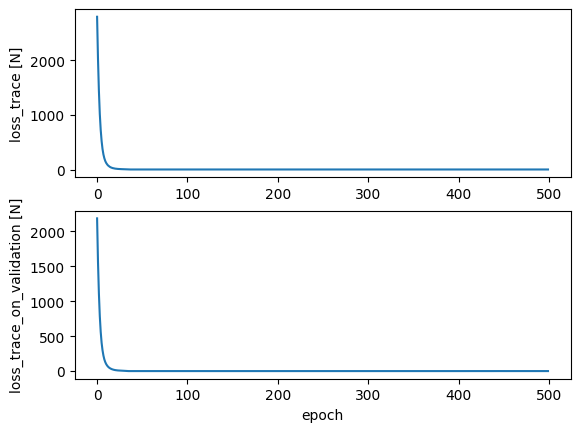

In [2]:
# use the data from previous section to train the model

factory = training_manager.PipelineFactory(is_diaml=False)
manager = factory.make_training_pipeline()
manager.set_up(
    training_data_menu=data_list,
    # training_data_menu=data_list[:4],    # use small data list for quick testing
    validation_data_menu=validation_list[-1:],
    input_label_map_file=path1,
    can_inspect_data=False
)
plt.show() 
manager.train()

plt.show()  

Inspect data in the data list.

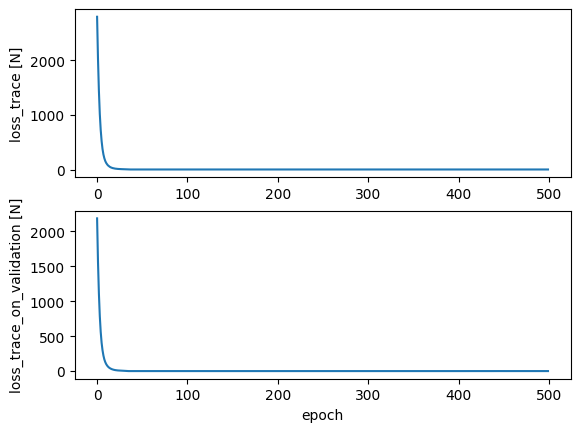

In [3]:
# trainer_instance.inspect_data(data_list[:2])
manager.show_result_only()

After training, we can save the model in the following way.

In [4]:
model_name = training_subfolder
manager.save_model(model_name)

Model saved to model\wind_near_wall_bemt_fitting.pth


Test the model using the test set.

test Data List:
wind_near_wall_bemt_fitting_validation\test_wind_near_wall_x0_0_y0_0_z10_0_d0_5_validation_no_bemt.csv
wind_near_wall_bemt_fitting_validation\test_wind_near_wall_x0_0_y0_0_z1_0_d0_5_validation_no_bemt.csv
wind_near_wall_bemt_fitting_validation\test_wind_near_wall_x0_0_y0_0_z4_0_d0_5_validation_no_bemt.csv
wind_near_wall_bemt_fitting_validation\test_wind_near_wall_x0_0_y0_0_zn10_0_d0_5_validation_no_bemt.csv
wind_near_wall_bemt_fitting_validation\test_wind_near_wall_x0_0_y0_0_zn1_0_d0_5_validation_no_bemt.csv
wind_near_wall_bemt_fitting_validation\test_wind_near_wall_x0_0_y0_0_zn4_0_d0_5_validation_no_bemt.csv
wind_near_wall_bemt_fitting_validation\test_wind_near_wall_xn2_0_y0_0_z10_0_d0_5_validation_no_bemt.csv
wind_near_wall_bemt_fitting_validation\test_wind_near_wall_xn2_0_y0_0_z1_0_d0_5_validation_no_bemt.csv
wind_near_wall_bemt_fitting_validation\test_wind_near_wall_xn2_0_y0_0_z4_0_d0_5_validation_no_bemt.csv
wind_near_wall_bemt_fitting_validation\test_wind_near_wal

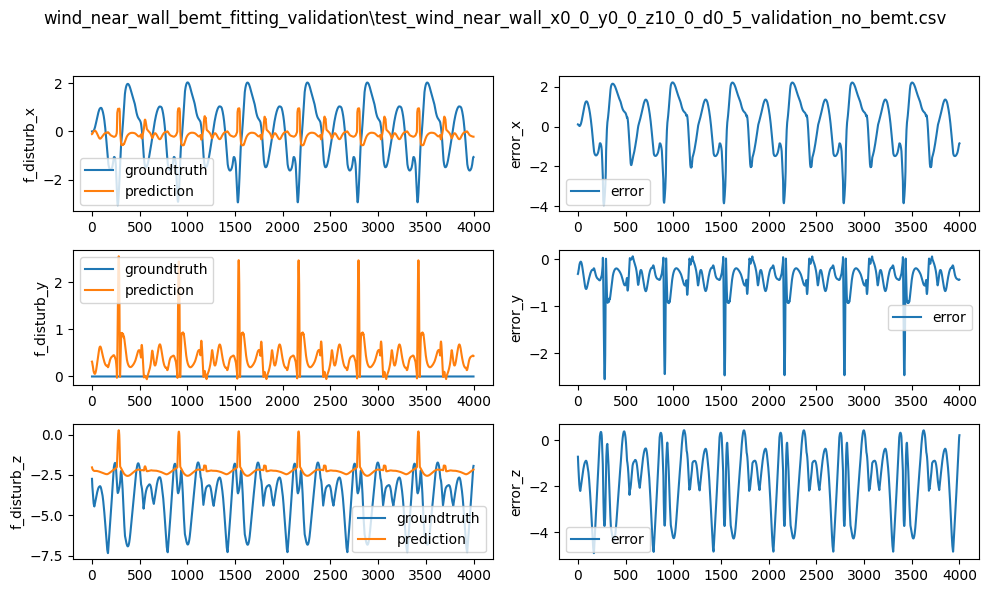

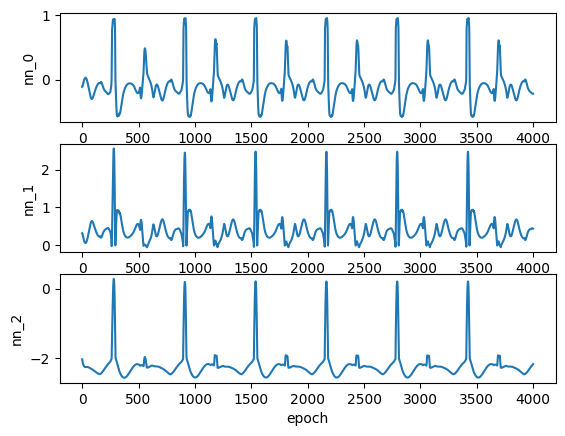

prediction: tensor([[ 0.0726,  0.0554, -1.2970],
        [ 0.0742,  0.0519, -1.3028],
        [ 0.0795,  0.0426, -1.3076],
        ...,
        [ 0.1675, -0.1349, -1.1025],
        [ 0.1759, -0.1508, -1.0979],
        [ 0.1845, -0.1668, -1.0934]])


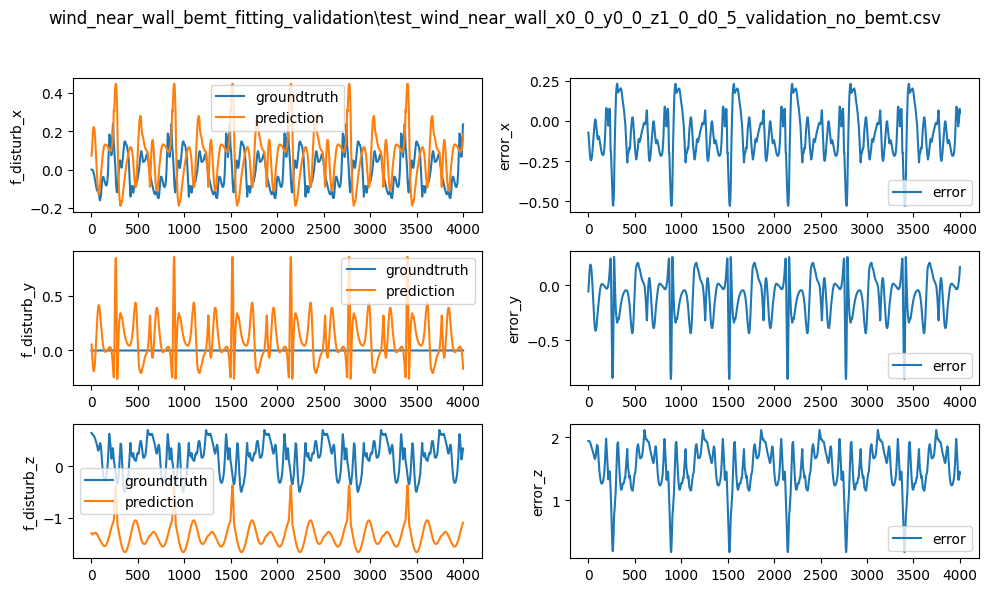

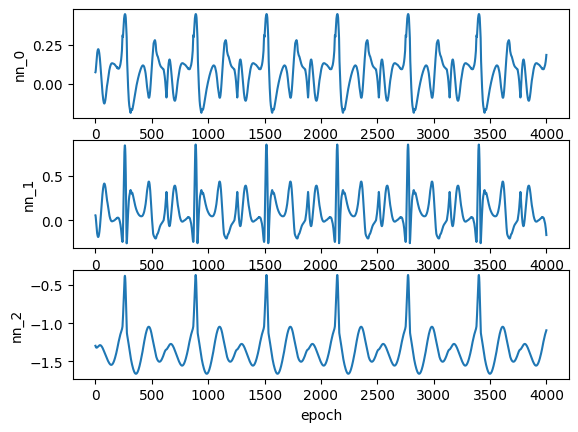

prediction: tensor([[ 0.0120,  0.1424, -1.5406],
        [ 0.0132,  0.1390, -1.5504],
        [ 0.0181,  0.1298, -1.5589],
        ...,
        [ 0.0835, -0.0163, -1.3897],
        [ 0.0906, -0.0301, -1.3855],
        [ 0.0979, -0.0441, -1.3814]])


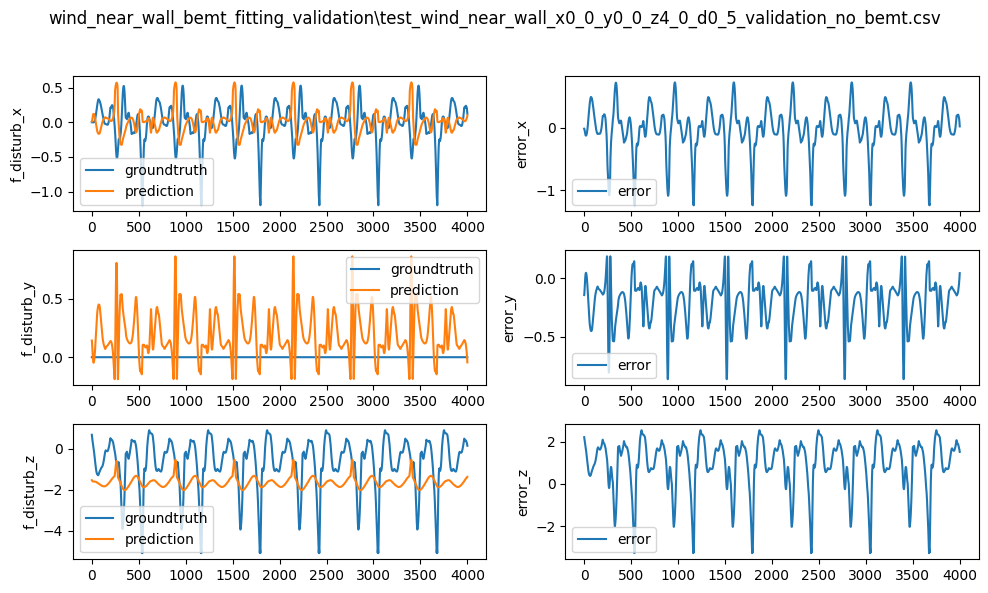

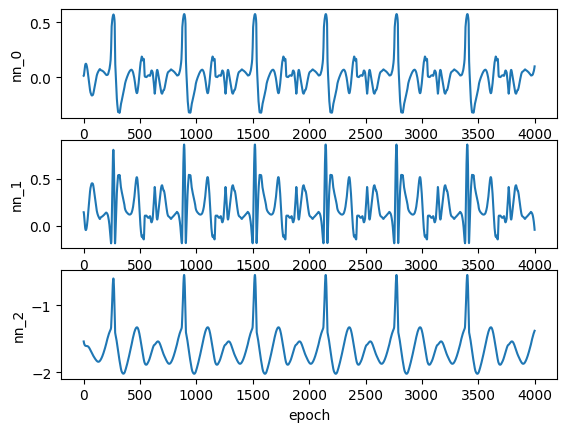

prediction: tensor([[ 0.2941, -0.2635, -0.4052],
        [ 0.2949, -0.2668, -0.4201],
        [ 0.2993, -0.2758, -0.4327],
        ...,
        [ 0.2385, -0.3794, -0.1943],
        [ 0.2374, -0.3745, -0.1741],
        [ 0.2364, -0.3696, -0.1540]])


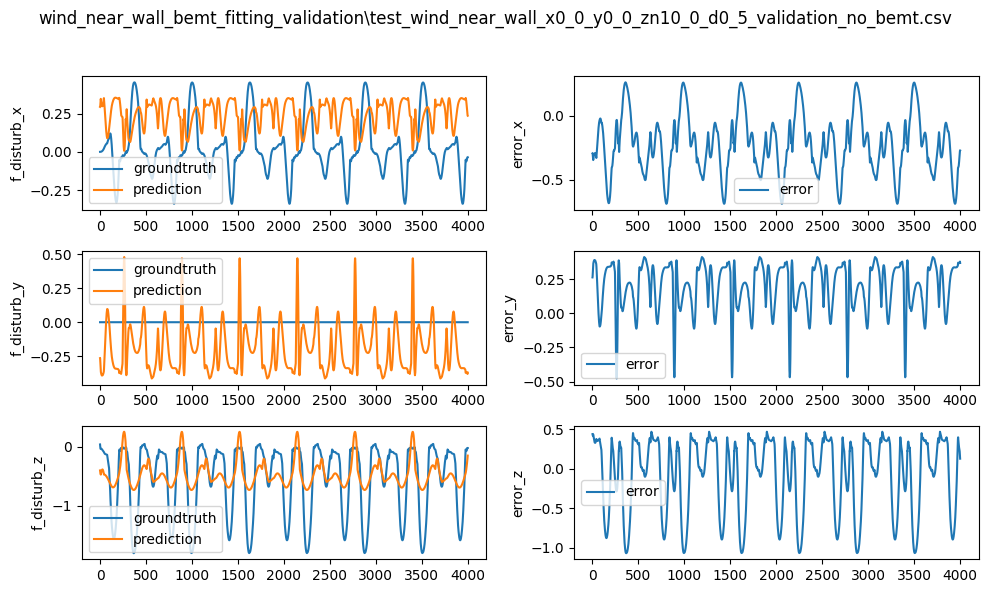

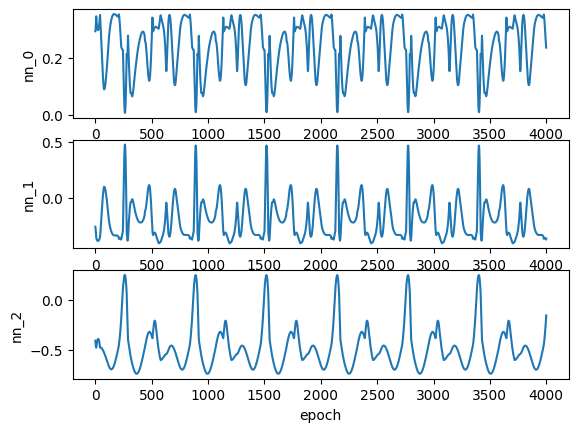

prediction: tensor([[ 0.1131, -0.0027, -1.1345],
        [ 0.1151, -0.0062, -1.1358],
        [ 0.1208, -0.0157, -1.1365],
        ...,
        [ 0.1950, -0.1711, -0.9431],
        [ 0.2029, -0.1860, -0.9388],
        [ 0.2108, -0.2009, -0.9346]])


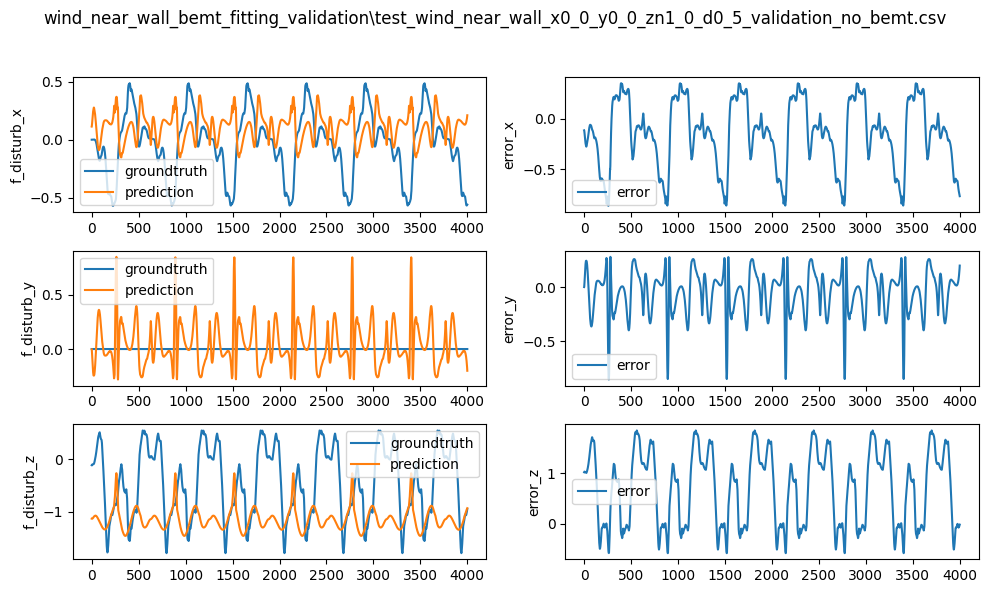

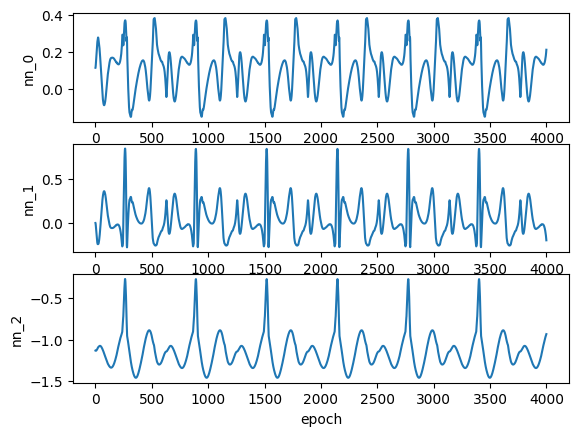

prediction: tensor([[ 0.1736, -0.0897, -0.8912],
        [ 0.1755, -0.0932, -0.8933],
        [ 0.1811, -0.1026, -0.8947],
        ...,
        [ 0.2585, -0.2646, -0.7274],
        [ 0.2642, -0.2760, -0.7233],
        [ 0.2703, -0.2878, -0.7194]])


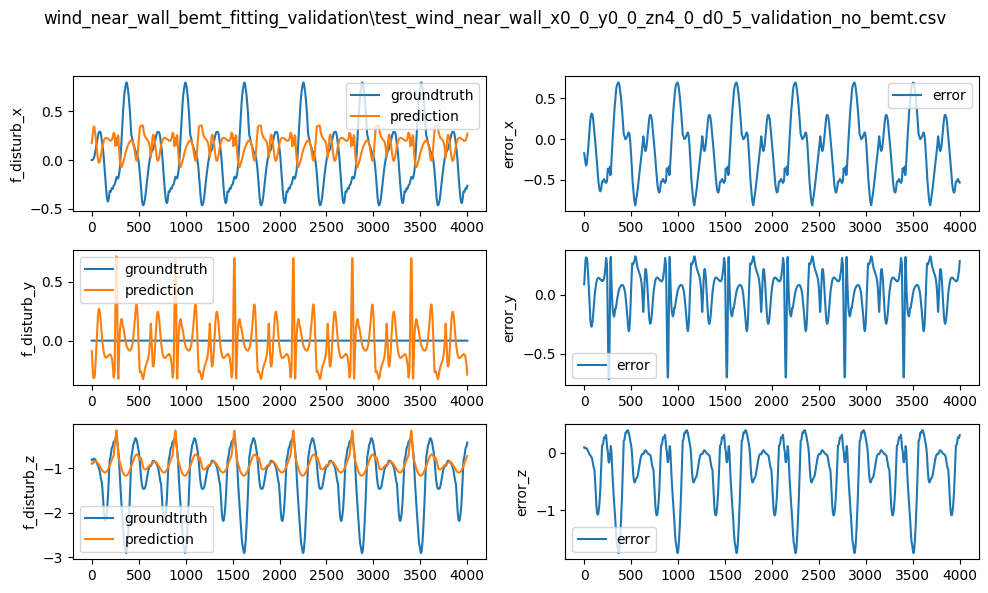

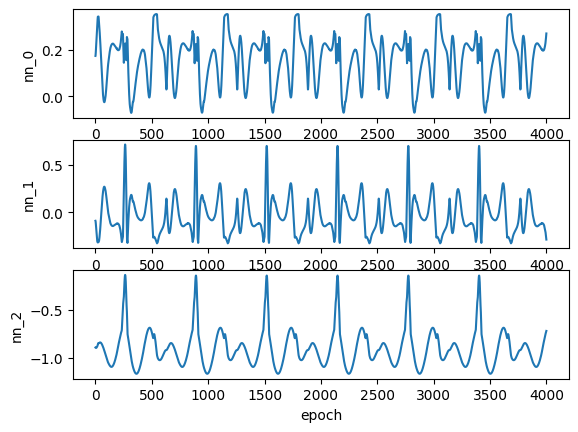

prediction: tensor([[-0.1237,  0.3264, -2.0491],
        [-0.1090,  0.2989, -2.0719],
        [-0.0944,  0.2719, -2.0920],
        ...,
        [-0.2110,  0.4042, -2.2051],
        [-0.2105,  0.4017, -2.2019],
        [-0.2100,  0.3989, -2.1988]])


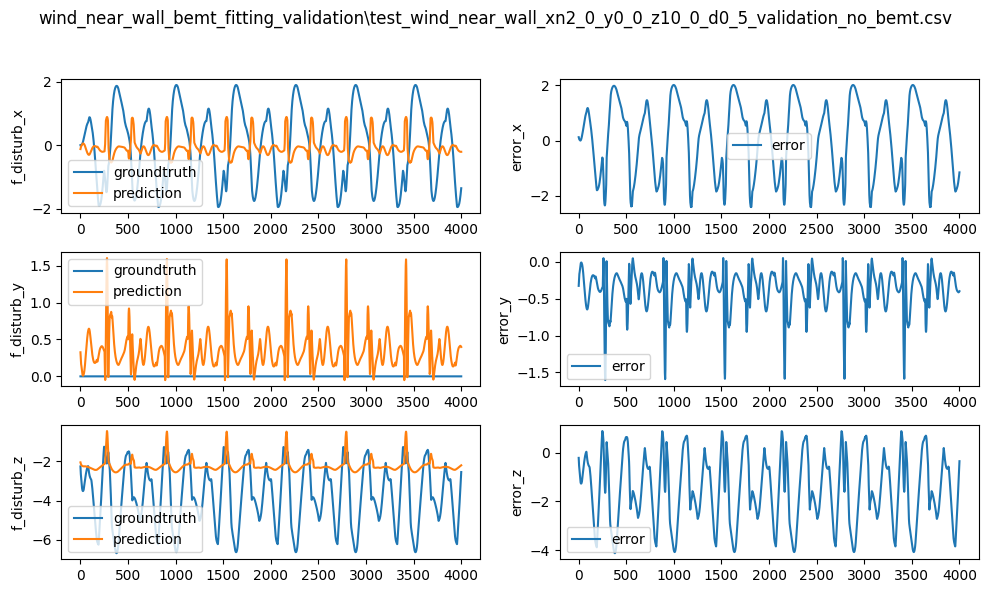

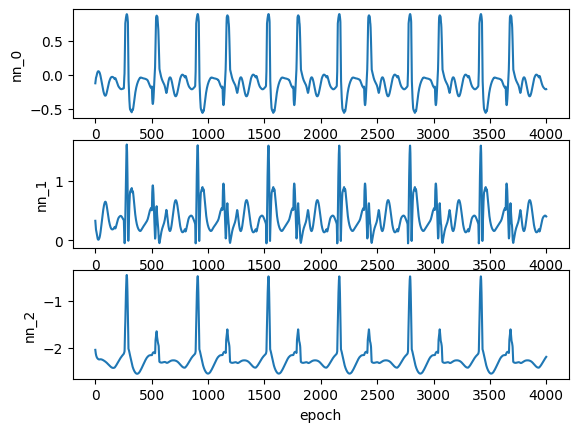

prediction: tensor([[ 0.0583,  0.0652, -1.3182],
        [ 0.0715,  0.0425, -1.3242],
        [ 0.0845,  0.0203, -1.3291],
        ...,
        [ 0.1553, -0.1344, -1.1512],
        [ 0.1617, -0.1470, -1.1468],
        [ 0.1685, -0.1601, -1.1426]])


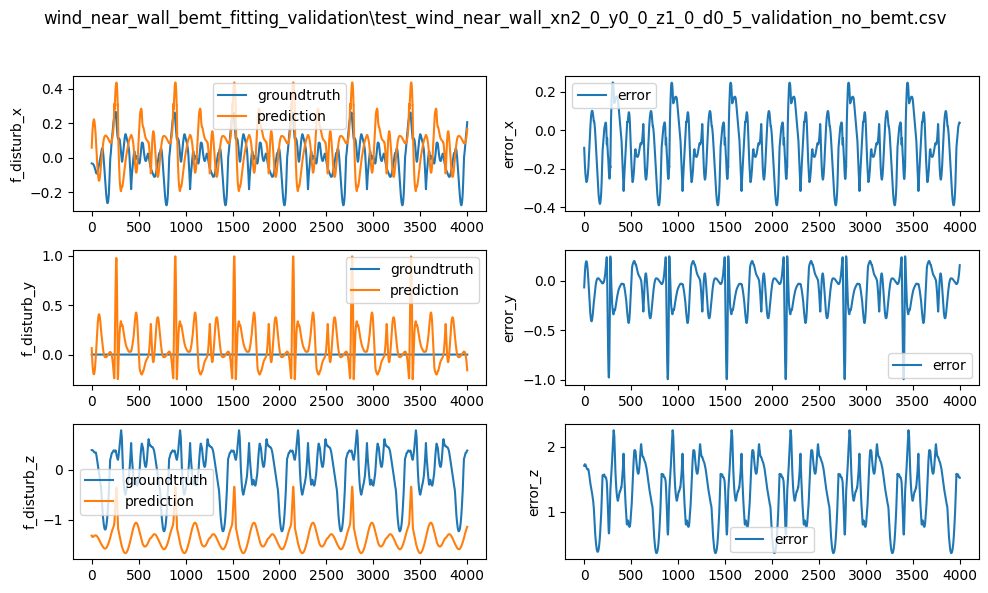

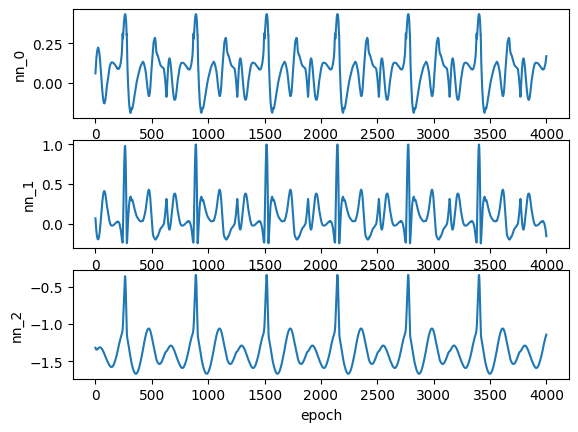

prediction: tensor([[-0.0024,  0.1523, -1.5620],
        [ 0.0083,  0.1326, -1.5756],
        [ 0.0191,  0.1132, -1.5873],
        ...,
        [ 0.0768, -0.0217, -1.4272],
        [ 0.0870, -0.0405, -1.4223],
        [ 0.0982, -0.0611, -1.4177]])


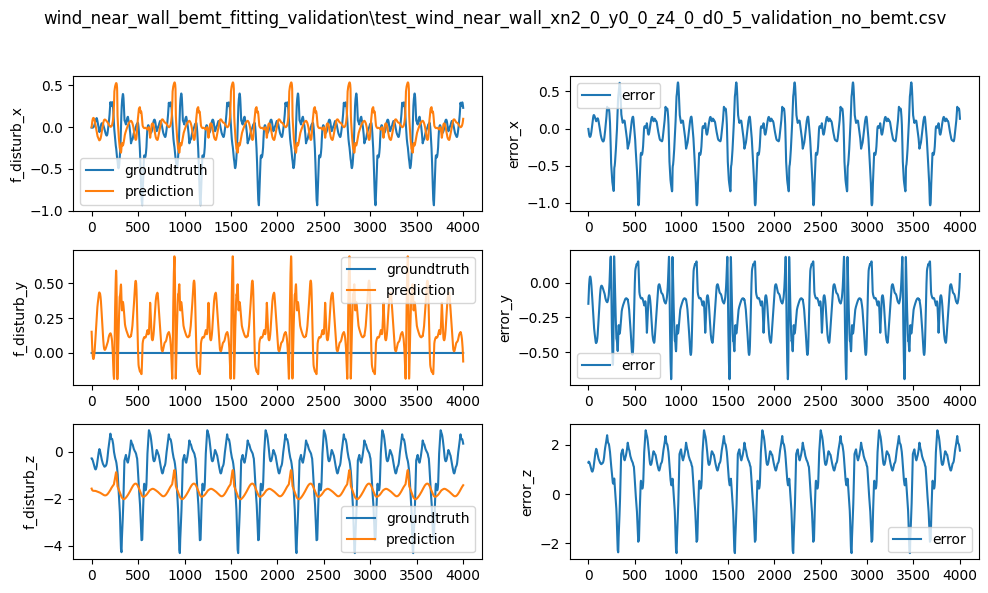

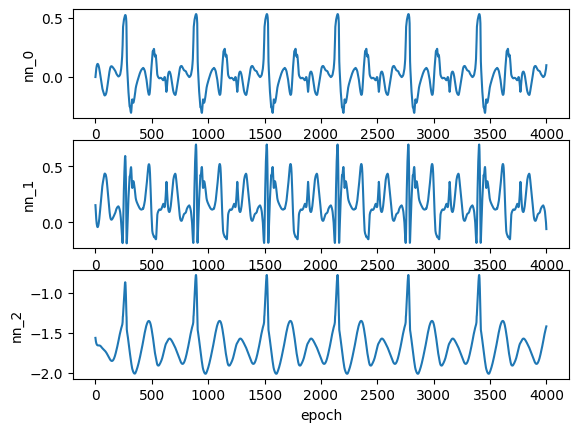

prediction: tensor([[ 0.2798, -0.2537, -0.4263],
        [ 0.2991, -0.2874, -0.4400],
        [ 0.3155, -0.3162, -0.4515],
        ...,
        [ 0.2371, -0.3586, -0.1693],
        [ 0.2359, -0.3541, -0.1506],
        [ 0.2347, -0.3500, -0.1339]])


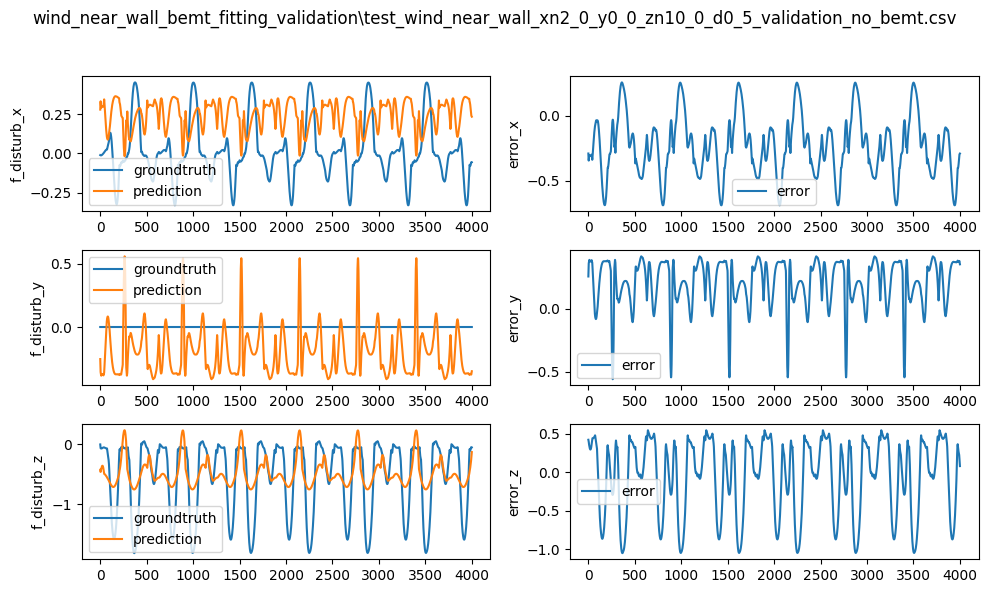

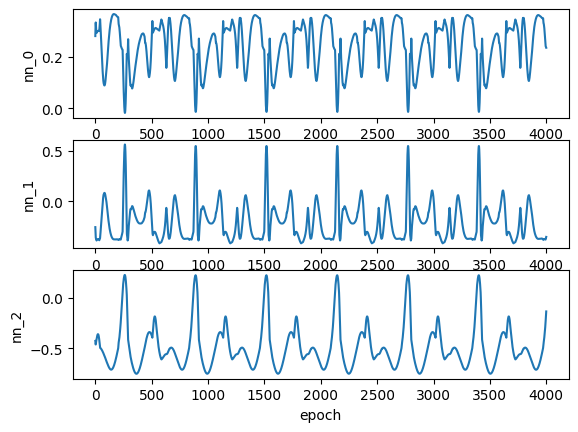

prediction: tensor([[ 0.0988,  0.0071, -1.1558],
        [ 0.1128, -0.0163, -1.1571],
        [ 0.1263, -0.0387, -1.1579],
        ...,
        [ 0.1975, -0.1925, -0.9667],
        [ 0.2053, -0.2072, -0.9623],
        [ 0.2130, -0.2219, -0.9581]])


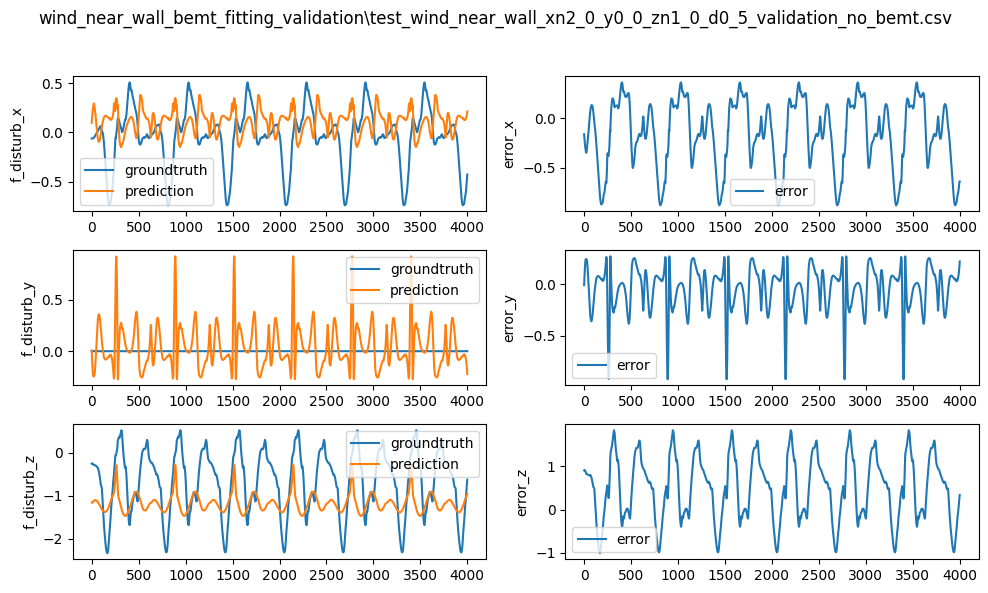

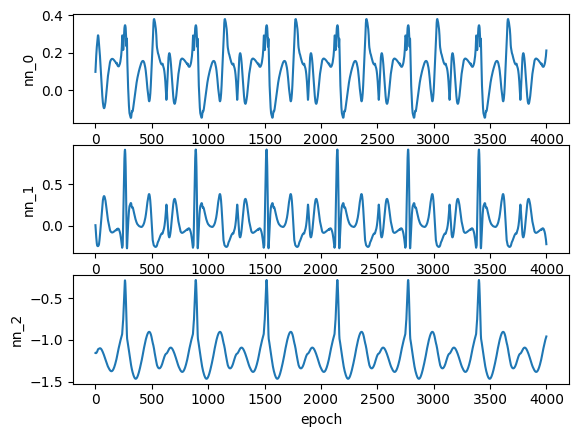

prediction: tensor([[ 0.1592, -0.0799, -0.9124],
        [ 0.1763, -0.1084, -0.9141],
        [ 0.1917, -0.1340, -0.9153],
        ...,
        [ 0.2587, -0.2813, -0.7423],
        [ 0.2645, -0.2928, -0.7382],
        [ 0.2726, -0.3079, -0.7338]])


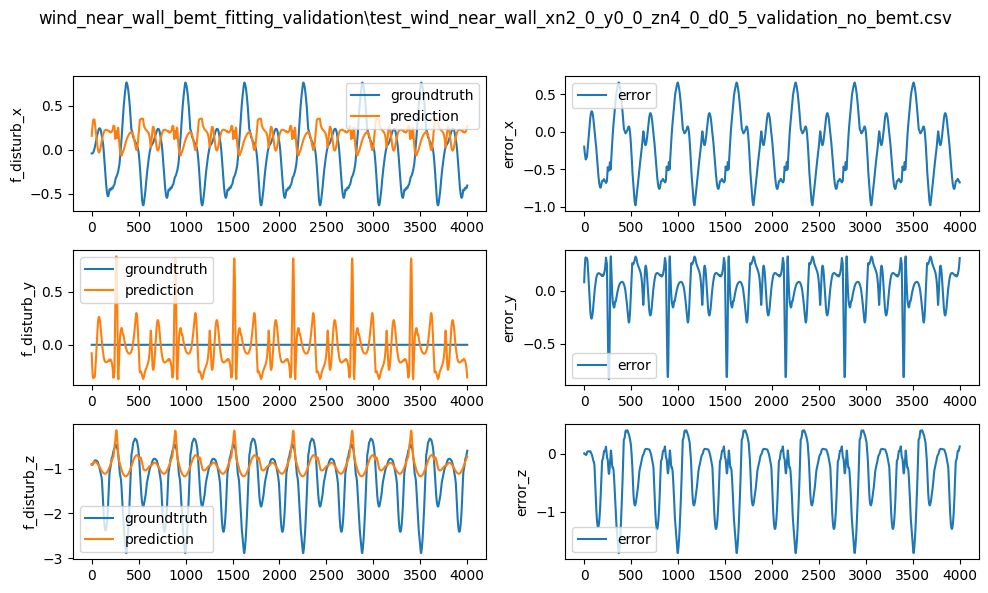

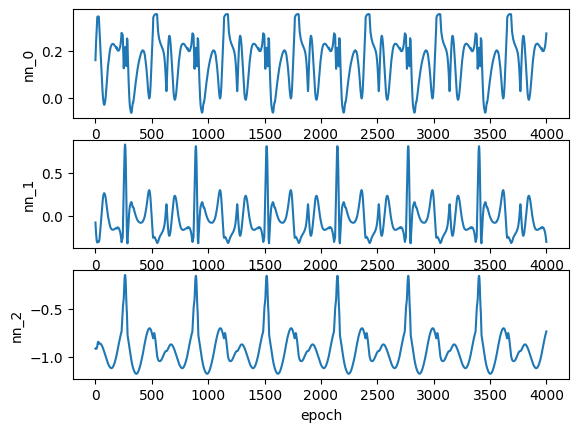

prediction: tensor([[-0.1451,  0.3411, -2.0808],
        [-0.1091,  0.2785, -2.1012],
        [-0.0795,  0.2269, -2.1192],
        ...,
        [-0.1888,  0.3354, -2.2365],
        [-0.1894,  0.3346, -2.2337],
        [-0.1899,  0.3334, -2.2310]])


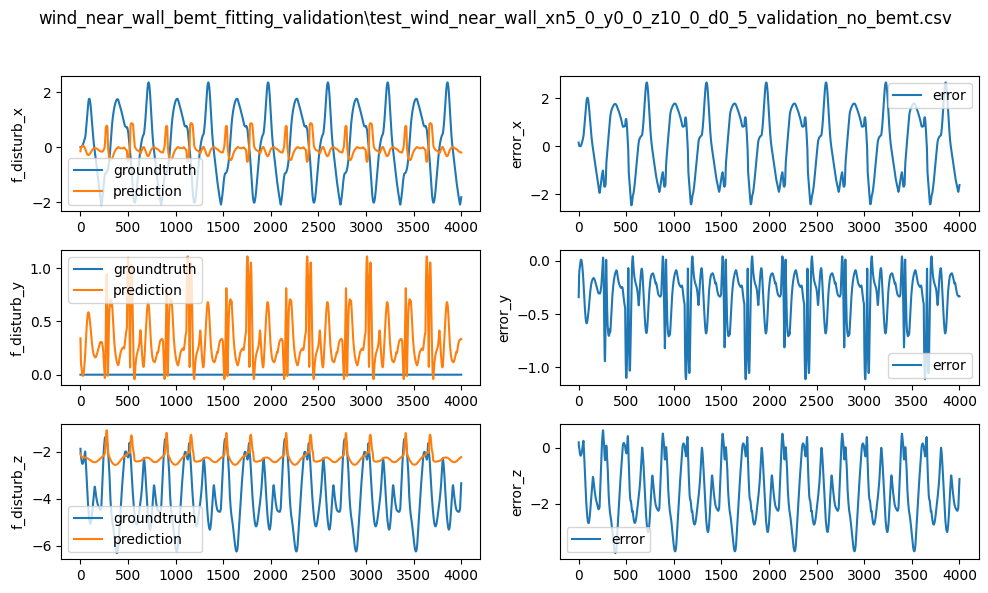

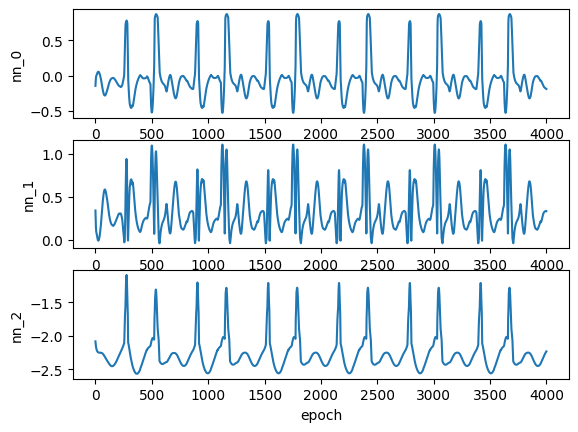

prediction: tensor([[ 0.0368,  0.0799, -1.3501],
        [ 0.0682,  0.0269, -1.3571],
        [ 0.0932, -0.0153, -1.3629],
        ...,
        [ 0.1320, -0.1246, -1.2232],
        [ 0.1386, -0.1375, -1.2184],
        [ 0.1457, -0.1511, -1.2138]])


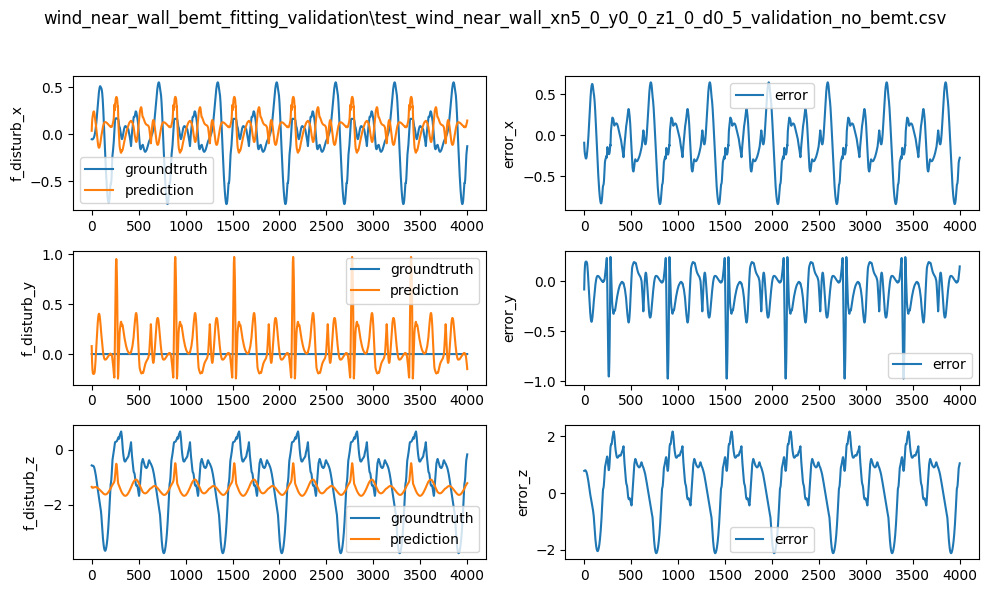

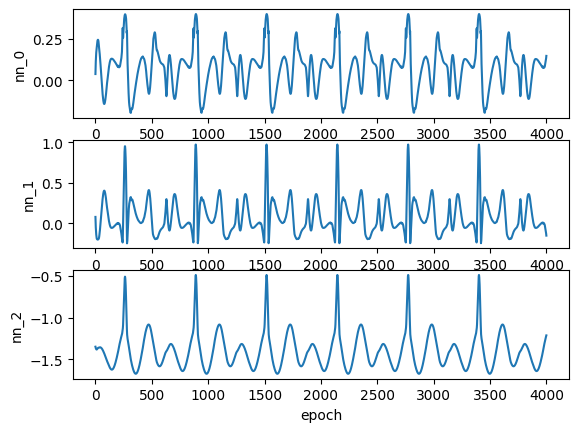

prediction: tensor([[-0.0239,  0.1670, -1.5937],
        [ 0.0173,  0.0970, -1.6057],
        [ 0.0503,  0.0409, -1.6160],
        ...,
        [ 0.0756, -0.0540, -1.5454],
        [ 0.0797, -0.0627, -1.5421],
        [ 0.0833, -0.0708, -1.5389]])


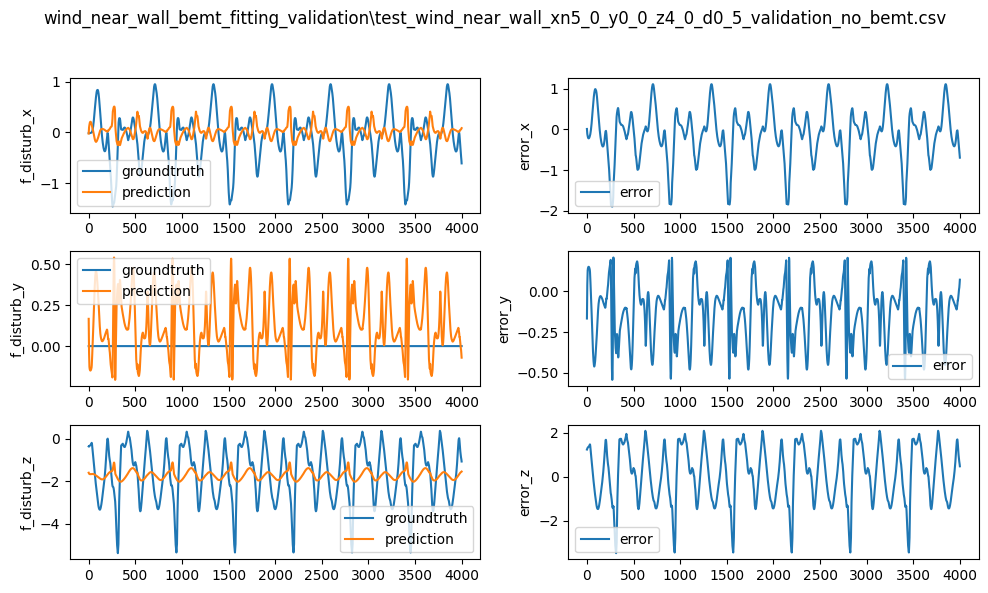

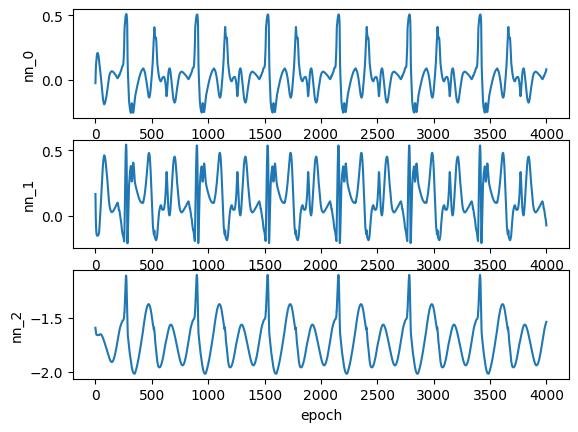

prediction: tensor([[ 0.2584, -0.2390, -0.4581],
        [ 0.3055, -0.3188, -0.4709],
        [ 0.3089, -0.3582, -0.4562],
        ...,
        [ 0.2310, -0.3273, -0.1290],
        [ 0.2298, -0.3228, -0.1105],
        [ 0.2287, -0.3181, -0.0914]])


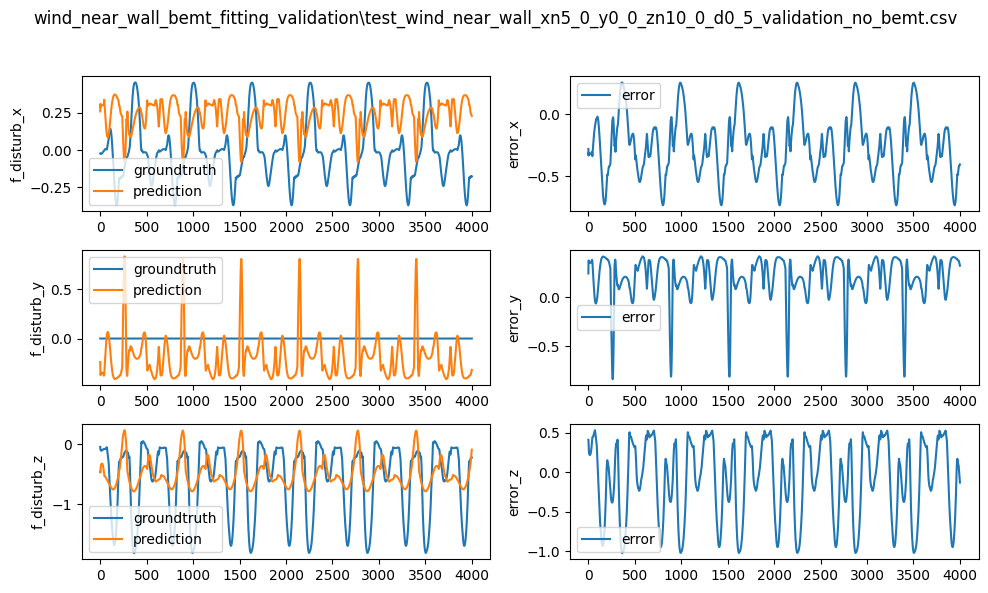

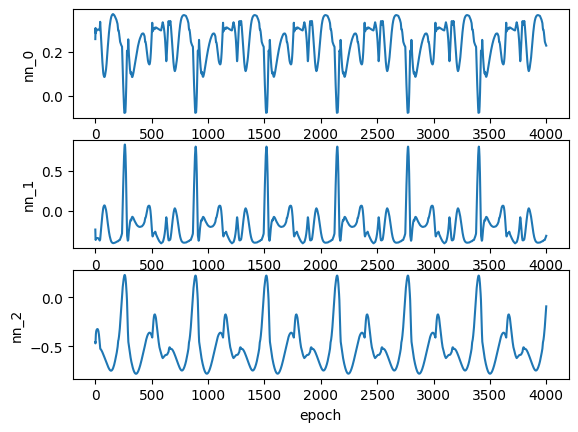

prediction: tensor([[ 0.0773,  0.0218, -1.1876],
        [ 0.1061, -0.0262, -1.1902],
        [ 0.1291, -0.0647, -1.1922],
        ...,
        [ 0.1887, -0.2073, -1.0394],
        [ 0.1951, -0.2198, -1.0353],
        [ 0.2016, -0.2325, -1.0314]])


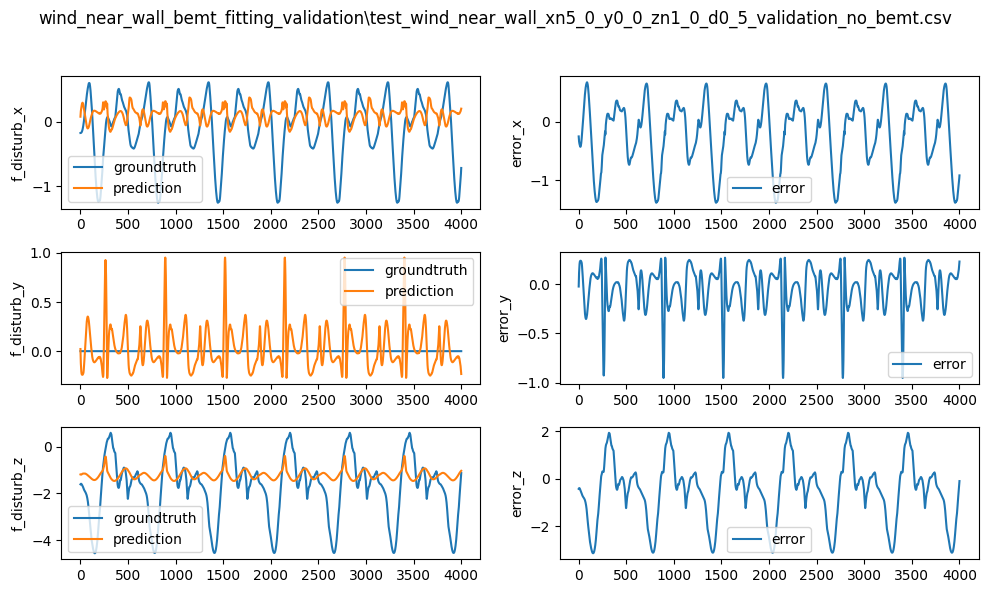

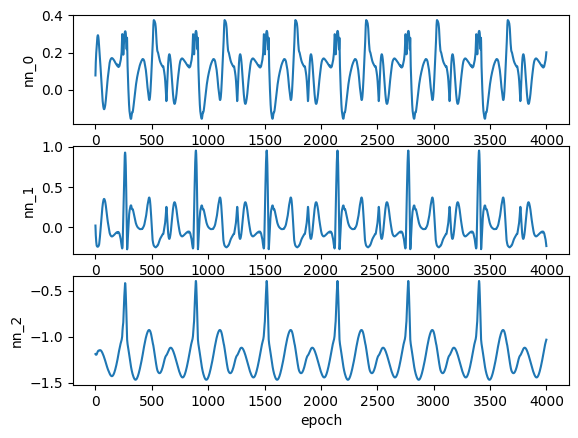

prediction: tensor([[ 0.1378, -0.0652, -0.9442],
        [ 0.1782, -0.1324, -0.9456],
        [ 0.2087, -0.1830, -0.9465],
        ...,
        [ 0.2657, -0.2994, -0.7697],
        [ 0.2748, -0.2997, -0.7560],
        [ 0.2732, -0.2933, -0.7338]])


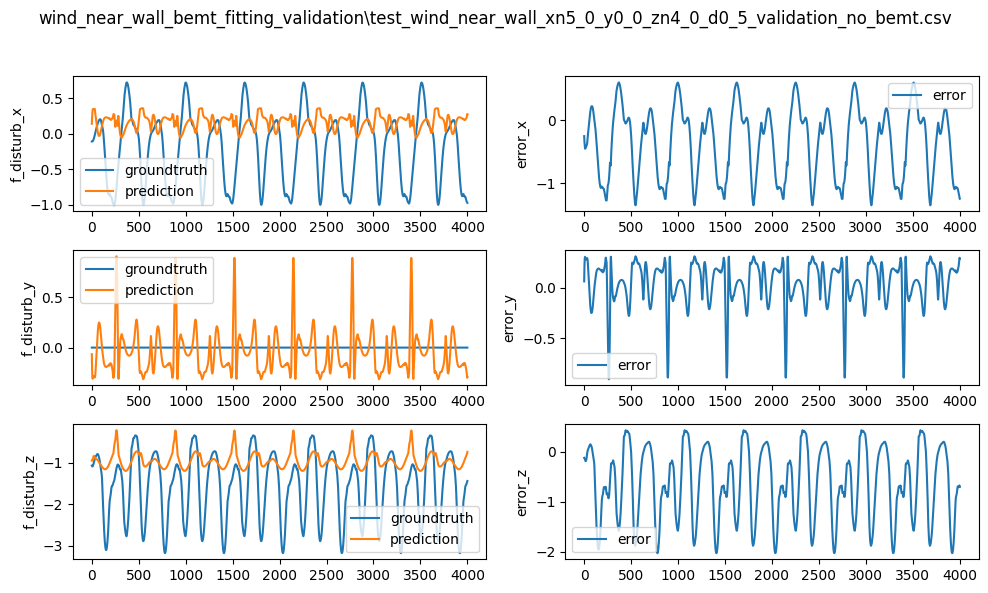

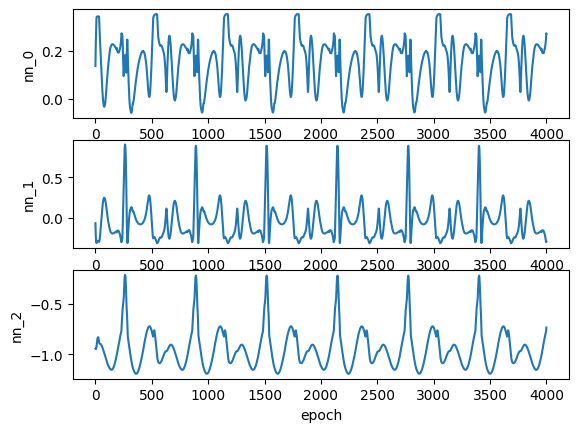

average rms for dim 0: 0.5565032570948001
average rms for dim 1: 0.274396402436571
average rms for dim 2: 1.2002771351142045


c:\YimingVirtualDDrive\7_workSpace\repo\neural-fly\Simulation\learning\validator.py:362: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


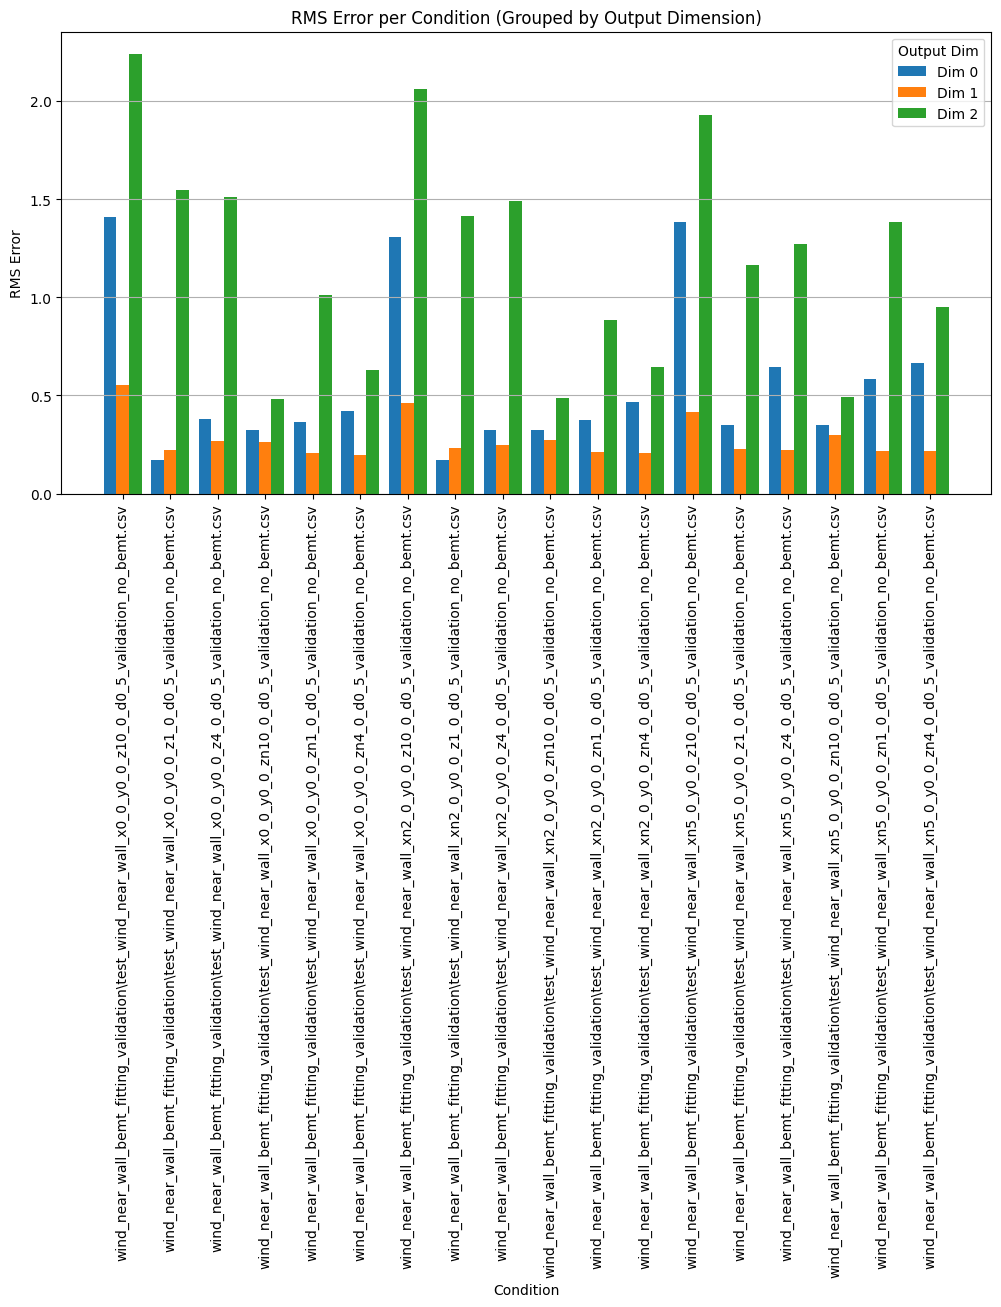

average mse for dim 0: 0.4581037761648562
average mse for dim 1: 0.0846748437018561
average mse for dim 2: 1.7242796636503357


c:\YimingVirtualDDrive\7_workSpace\repo\neural-fly\Simulation\learning\validator.py:401: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


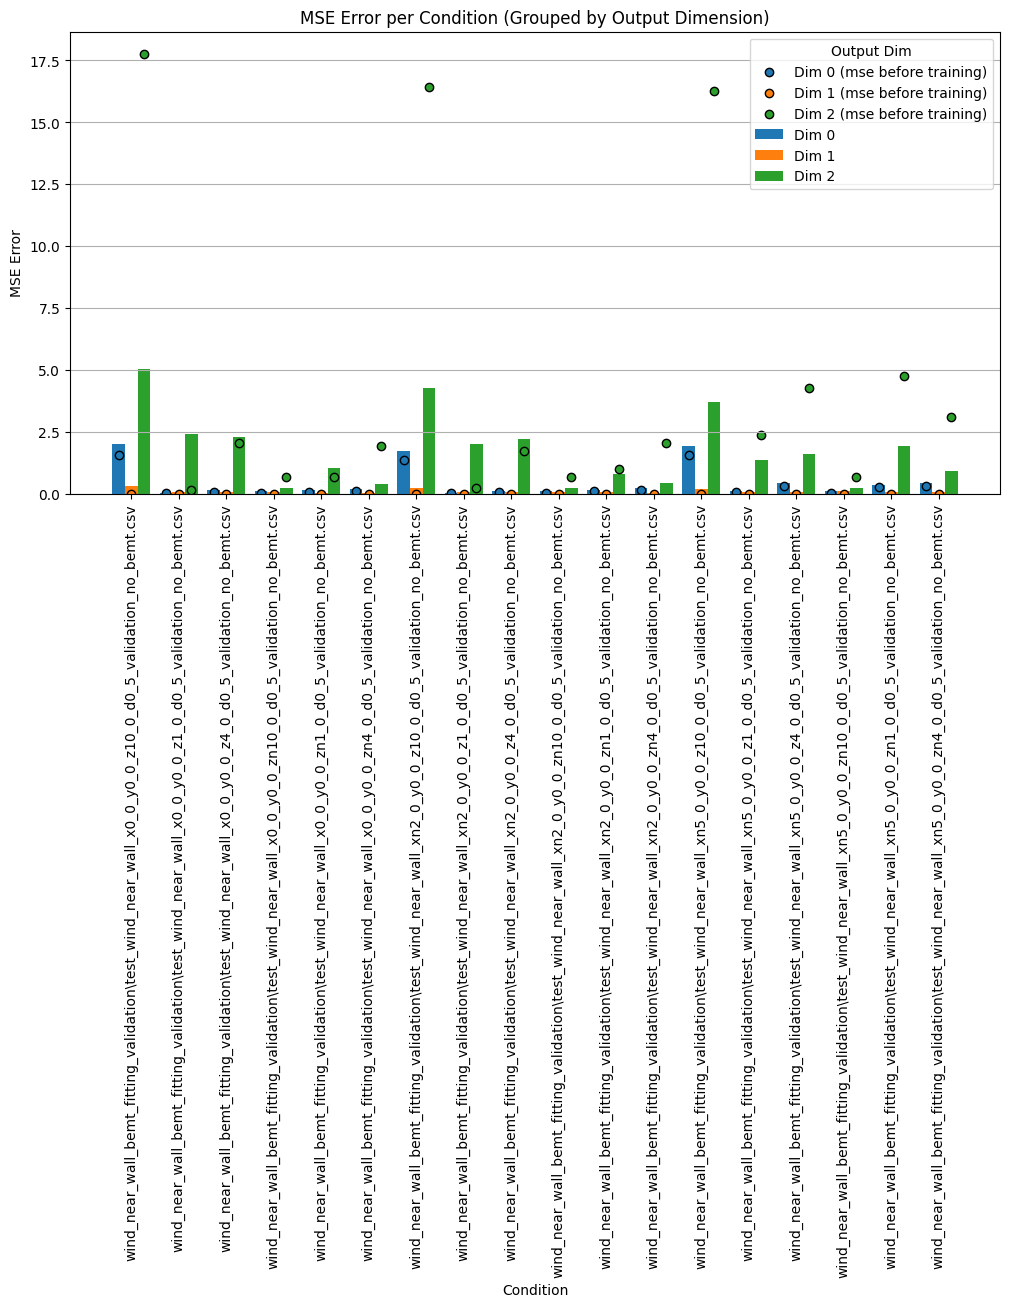

In [5]:
%matplotlib inline
model_name = training_subfolder

subfolder = validation_subfolder
# subfolder = "wind_near_wall_bemt_fitting_validation"
# subfolder = "nf_validation_back2back"
data_list = generate_data_list(subfolder)
print("test Data List:")
for data in data_list:
    print(data)

# debug
# data_list = data_list[:1]  # use small data list for quick testing

manager = factory.make_test_pipeline()

manager.set_up(
    data_menu=data_list,
    input_label_map_file=path1,
    model_name=model_name
)

# make a new trainer to replicate the above setup, just to allow verify_model to work
manager.test()
plt.show()  
